# [NAPARI](https://napari.org/) testing
## and adding [cellpose](https://cellpose-napari.readthedocs.io/en/latest/index.html) (installer [here](https://pypi.org/project/cellpose-napari/0.1.3/))

To upgrade run in a cell:
```python
!pip install cellpose-napari==0.1.3
!pip install cellpose --upgrade
```

```bash
napari -w cellpose-napari
```

### Basic usage:
```python
viewer = napari.view_image(data.astronaut(), rgb=True)
nbscreenshot(viewer)
viewer.close()
```

example notebooks [here](https://github.com/sofroniewn/napari-training-course/blob/master/lessons/)

In [ ]:
## to install
# !pip install napari[all]
# !pip install QT
# !pip install napari[pyqt5]
# !pip install cellpose-napari==0.1.3
# !pip install napari-nikon-nd2
# !pip install magicgui
# !pip install napari-pyclesperanto-assistant

## to upgrade:
# !pip install cellpose-napari==0.1.3
# !pip install cellpose --upgrade
# !pip install napari[all] --upgrade

In [1]:
import napari
import cellpose_napari
from napari.utils import nbscreenshot
from tifffile import imread
import numpy as np
from scipy import ndimage
from scipy.stats import mannwhitneyu
import napari_nikon_nd2
import os 
from magicgui import magicgui
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import importlib
import svgutils
from svgutils.compose import *
from cmcrameri import cm #colormaps

2021-08-09 11:27:31,603 [INFO] WRITING LOG OUTPUT TO /Users/angueyraaristjm/.cellpose/run.log


In [9]:
# plotStyle = 'dark';
plotStyle = 'light';


batlow = cm.vik(range(255))
batlow = batlow[0:255:np.int(np.floor(255/8)),:]
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=batlow) 

#gene Colors
zfC = {
    'rho'  : '#7d7d7d',
    'sws1' : '#B73AB9',
    'sws2' : '#4364F6',
    'mws1' : '#59CB3B',
    'mws2' : '#59CB3B',
    'mws3' : '#59CB3B',
    'mws4' : '#59CB3B',
    'lws1' : '#CE2A22',
    'lws2' : '#CE2A22',
    'actb2': '#926645',
    'tbx2a': '#c92675',
    'tbx2b': '#7526c9',
    'six7' : '#d6ab00',
}

if plotStyle=='dark':
    # dark background
    params = {"ytick.color" : "w",
              "xtick.color" : "w",
              "axes.labelcolor" : "w",
              "axes.edgecolor" : "w",
             "axes.linewidth" : 3,
             "xtick.major.width" : 3,
             "ytick.major.width" : 3,
             "xtick.major.size" : 8,
             "ytick.major.size" : 8,
             "text.color" : "w"}
    plt.rcParams.update(params)
elif plotStyle=='light':
    # white background
    params = {"ytick.color" : "k",
              "xtick.color" : "k",
              "axes.labelcolor" : "k",
              "axes.edgecolor" : "k",
             "axes.linewidth" : 3,
             "xtick.major.width" : 3,
             "ytick.major.width" : 3,
             "xtick.major.size" : 8,
             "ytick.major.size" : 8,
             "text.color" : "k"}
    plt.rcParams.update(params)

def formatFigureMain(figH, axH, plotH):
    font_path = '/System/Library/Fonts/Avenir.ttc'
    fontTicks = font_manager.FontProperties(fname=font_path, size=22)
    fontLabels = font_manager.FontProperties(fname=font_path, size=28)
    fontTitle = font_manager.FontProperties(fname=font_path, size=32)
    axH.set_xscale('linear')
    axH.spines['top'].set_visible(False)
    axH.spines['right'].set_visible(False)
    
    for label in (axH.get_xticklabels() + axH.get_yticklabels()):
        label.set_fontproperties(fontTicks)
    axH.set_xlabel(axH.get_xlabel(), fontproperties = fontTicks)
    axH.set_ylabel(axH.get_ylabel(), fontproperties = fontTicks)
    return fontLabels

# viewer = napari.Viewer()

print('Opened viewer; plot style is ' + plotStyle)

Opened viewer; plot style is light


***
# Index <a id='Index'>∮</a>
***
- [Test segmentation (initial](#testSeg)
- [Extraction of z planes for analysis](#zExtract)
- [Segmentation with cellpose](#cellSeg)
- [Manual correction of segmentation](#manualCuration)
- [Create thumbnails _WIP_](#thumbnails)
- [Quantification](#quantification)

***
## Testing segmentation<a id='testSeg'>∮</a>
***
[Back to Index](#Index)

In [ ]:
# clear viewer
viewer.layers.select_all()
viewer.layers.remove_selected()

In [ ]:
dPath = "/Users/angueyraaristjm/Documents/LiImaging/A1R/zf_partial/20201009_CRtbx2a/"
fPathL = "20201009_i06b_L"
fPathM = "20201009_i06b_M"
# load the image data and inspect its shape
zfL = imread(dPath+fPathL + ".tiff")
zfM = imread(dPath+fPathM + ".tiff")
viewer.add_image(zfL, colormap='magenta')#, contrast_limits=[196,5860]);
viewer.add_image(zfM, colormap='green', blending='additive')#, contrast_limits=[223,6721]);
viewer.open(dPath+fPathL + "_seg.tiff", name='zfL_seg', plugin='builtins');
viewer.open(dPath+fPathM + "_seg.tiff", name='zfM_seg', plugin='builtins');
# nbscreenshot(viewer)

In [ ]:
nL = len(np.unique(viewer.layers['zfL_seg'].data))-1
print("Image has {0} L cones".format(nL))
nM = len(np.unique(viewer.layers['zfM_seg'].data))-1
print("Image has {0} M cones".format(nM))

dL = viewer.layers['zfL_seg'].data
dM = viewer.layers['zfM_seg'].data

Not sure how to normalize across images...
1. average GFP instensity inside M-cones? &rarr; difficult in CRISPants
1. max GFP intensity? &rarr; could be ok

In [ ]:
# eroding segmentation because it too generous with ROIs and I want to exclude GFP diffraction
viewer.layers['zfL_seg'].data = ndimage.grey_erosion(dL, size=(8,8))
viewer.layers['zfM_seg'].data = ndimage.grey_erosion(dM, size=(8,8))

L_avgG = np.zeros([nL,1])
L_avgR = np.zeros([nL,1])
# calculate mean GFP intensity inside each L cone (normalized and baseline subtracted)
maxM = viewer.layers['zfM'].data[viewer.layers['zfL_seg'].data == 0].max()
maxL = viewer.layers['zfL'].data[viewer.layers['zfL_seg'].data == 1].max()
minM = viewer.layers['zfM'].data[viewer.layers['zfL_seg'].data == 0].min()
minL = viewer.layers['zfL'].data[viewer.layers['zfL_seg'].data == 0].min()
for roi in range(nL):
    tempROI = viewer.layers['zfL_seg'].data == roi
    L_avgG[roi] = (viewer.layers['zfM'].data[tempROI].mean()-minM)/(maxM-minM)
    L_avgR[roi] = (viewer.layers['zfL'].data[tempROI].mean()-minL)/(maxL-minL)

M_avgG = np.zeros([nM,1])
M_avgR = np.zeros([nM,1])
# calculate mean GFP intensity inside each M cone (normalized and baseline subtracted)
for roi in range(nM):
    tempROI = viewer.layers['zfM_seg'].data == roi
    M_avgG[roi] = (viewer.layers['zfM'].data[tempROI].mean()-minM)/(maxM-minM)
    M_avgR[roi] = (viewer.layers['zfL'].data[tempROI].mean()-minL)/(maxL-minL)

    
nbins = 20
denseFlag = True
    
plt.figure(figsize=(8,6))
plt.hist(L_avgG, bins=np.divide(range(0,nbins+1),nbins), density = denseFlag, color = (1.0,0.5,0.0,0.5), label="L_GFP")
plt.hist(L_avgR, bins=np.divide(range(0,nbins+1),nbins), density = denseFlag, color = (1.0,0.0,0.0,0.5), label="L_tdT")

plt.hist(M_avgG, bins=np.divide(range(0,nbins+1),nbins), density = denseFlag, color = (0.0,1.0,0.0,0.5), label="M_GFP")
plt.hist(M_avgR, bins=np.divide(range(0,nbins+1),nbins), density = denseFlag, color = (0.5,1.0,0.0,0.5), label="M_tdT")

plt.xlabel("Normalized intensity", size=14)
plt.ylabel("Probability", size=14)
plt.title("")
plt.legend(loc='upper right')
# plt.savefig("overlapping_histograms_with_matplotlib_Python.png")

In [ ]:
# viewer.layers['zfM_seg'].data = dM
viewer.layers['zfL_seg'].data = ndimage.grey_erosion(viewer.layers['zfL_seg'].data, size=(10,10))

In [ ]:
@viewer.bind_key('k')
def toggle_sel(viewer):
    if (viewer.layers['zfM_seg'].show_selected_label == True):
        viewer.layers['zfM_seg'].show_selected_label = False
    elif (viewer.layers['zfM_seg'].show_selected_label == False):
        viewer.layers['zfM_seg'].show_selected_label = True

In [ ]:
viewer.layers['zfM_seg'].show_selected_label=False

In [ ]:
viewer.layers['zfM_seg'].data

In [ ]:
viewer = napari.Viewer()

In [ ]:
# viewer.close()

***
## Extract layers from z-stacks<a id='zExtract'>∮</a>
***
[Back to Index](#Index)

In [ ]:
# clear viewer
viewer.layers.select_all()
viewer.layers.remove_selected()

In [ ]:
# clear viewer
viewer.layers.select_all()
viewer.layers.remove_selected()

# analysis directory
dAnalysis = "/Users/angueyraaristjm/Documents/LiImaging/Analysis/CRtbx2F0s/m2Gt2T/"

# open file


# uninjected
dPath = "/Volumes/zfSSD/LiImaging/A1R/zf/20201009_CRtbx2a/"
### 20201009: imaged 3dpf and 5dpf larvae. Analyzing 5 dpf for paper
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i09b"; zlims = [39,43]; gene = 'wt';
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i09d"; zlims = [31,34]; gene = 'wt';
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i10b"; zlims = [33,36]; gene = 'wt';
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i10d"; zlims = [38,41]; gene = 'wt';
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i11b"; zlims = [25,27]; gene = 'wt'; # this one could be example
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i11d"; zlims = [31,34]; gene = 'wt';
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i12b"; zlims = [23,25]; gene = 'wt';
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i12d"; zlims = [31,34]; gene = 'wt';

# tbx2a
# dPath = "/Volumes/zfSSD/LiImaging/A1R/zf/20201009_CRtbx2a/"
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b"; zlims = [36,38]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b"; zlims = [36,38]; gene = 'tbx2a';
# #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08b"; zlims = [00,00]; gene = 'tbx2a'; #very curved stack. would require oblique cut
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08d"; zlims = [30,33]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09b"; zlims = [30,33]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09d"; zlims = [29,32]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10b"; zlims = [36,38]; gene = 'tbx2a'; # this could be example
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10d"; zlims = [45,47]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11b"; zlims = [20,23]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11d"; zlims = [28,30]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12b"; zlims = [23,25]; gene = 'tbx2a';
# #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12d"; zlims = [36,38]; gene = 'tbx2a'; # this in lens up

# #tbx2b
# dPath = "/Volumes/zfSSD/LiImaging/A1R/zf/20201030_CRtbx2ab/"
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07b"; zlims = [24,26]; gene = 'tbx2b';
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07d"; zlims = [37,39]; gene = 'tbx2b';
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08b"; zlims = [20,24]; gene = 'tbx2b';
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08d"; zlims = [27,29]; gene = 'tbx2b';

# uninjected
dPath = "/Volumes/angueyraNEI/LiImaging/A1R/zf2021onwards/20210716_tbx2F0s/"
### 20210716: imaged 5dpf larvae to increase n specifically for tbx2b
fPath = "20210716_5dpf_m2G_t2T_uninj_L101b"; zlims = [00,00]; zlims2 = [18,28]; gene = 'wt';
# fPath = "20210716_5dpf_m2G_t2T_uninj_L101d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt';
# fPath = "20210716_5dpf_m2G_t2T_uninj_L102b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt';
# fPath = "20210716_5dpf_m2G_t2T_uninj_L102d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt';
# fPath = "20210716_5dpf_m2G_t2T_uninj_L103b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt';
# fPath = "20210716_5dpf_m2G_t2T_uninj_L103d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt';
# fPath = "20210716_5dpf_m2G_t2T_uninj_L104b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt';
# fPath = "20210716_5dpf_m2G_t2T_uninj_L104d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt';
# fPath = "20210716_5dpf_m2G_t2T_uninj_L105b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt';
# fPath = "20210716_5dpf_m2G_t2T_uninj_L105d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt';
# fPath = "20210716_5dpf_m2G_t2T_uninj_L106b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt';
# fPath = "20210716_5dpf_m2G_t2T_uninj_L106d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt';

# # tbx2a
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L101b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2a';
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L101d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2a';
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L102b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2a';
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L102d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2a';
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L103b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2a';
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L103d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2a';
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L104b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2a';
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L104d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2a';
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L105b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2a';
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L105d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2a';
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L106b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2a';
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L106d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2a';

# # tbx2b
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L101b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L101d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L102b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L102d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L103b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L103d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L104b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L104d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L105b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L105d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L106b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L106d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L107b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L107d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L108b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L108d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L109b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L110b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L110d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L111b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L112b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'tbx2b';




# create subdirectory for analysis
dOut = dAnalysis + gene + '/' + fPath + '/'
if (os.path.isdir(dOut)==False):
    os.mkdir(dOut)

print('Canvas clear')

In [ ]:
# load whole stack to figure out best planes for cellpose
# dPath = "/Volumes/zfSSD/LiImaging/A1R/zf/20201030_CRtbx2ab/"
viewer.open((dPath+fPath + ".nd2"))
# viewer.layers.remove(viewer.layers[2]) # remove transmitted detector image
viewer.layers.remove(viewer.layers[3]) # remove transmitted detector image
viewer.layers[0].colormap = 'green'
viewer.layers[0].name = 'M'
viewer.layers[1].colormap = 'magenta'
viewer.layers[1].name = 'L'
viewer.layers[2].colormap = 'bop blue'
viewer.layers[2].name = 'LWS'
viewer.layers.select_next();
print('Loaded!')

In [ ]:
# make mips (and remove any previous ones)

# code for eyes with 1D4 immuno
zlims = [45,47]; # for FPs
zlims2 = [18,28]; # for OSs
if len(viewer.layers)>3:
    for l in viewer.layers[3:]:
        viewer.layers.remove(l)

for l in [viewer.layers[0],viewer.layers[1]]:
    l.visible = False
#     viewer.layers.remove(l.name + '_mip')
    viewer.add_image(l.data[zlims[0]:zlims[1]].max(axis=0), blending='additive', colormap = l.colormap, name = l.name + "_mip")
    
for l in [viewer.layers[2]]:
    l.visible = False
#     viewer.layers.remove(l.name + '_mip')
    viewer.add_image(l.data[zlims2[0]:zlims2[1]].max(axis=0), blending='additive', colormap = l.colormap, name = l.name + "_mip")

# # code for eyes without immuno
# # zlims = [45,47];
# if len(viewer.layers)>2:
#     for l in viewer.layers[2:]:
#         viewer.layers.remove(l)

# for l in [viewer.layers[0],viewer.layers[1]]:
#     l.visible = False
# #     viewer.layers.remove(l.name + '_mip')
#     viewer.add_image(l.data[zlims[0]:zlims[1]].max(axis=0), blending='additive', colormap = l.colormap, name = l.name + "_mip")

In [ ]:
# when things look good, save in folder for batch cellpose analysis
l = viewer.layers['M_mip']; l.save(dOut + l.name + '.tiff')
l = viewer.layers['L_mip']; l.save(dOut + l.name + '.tiff')

***
## Segmentation using cellpose<a id='cellSeg'>∮</a>
***
[Back to Index](#Index)

In [ ]:
# clear viewer
viewer.layers.select_all()
viewer.layers.remove_selected()

# analysis directory
dAnalysis = "/Users/angueyraaristjm/Documents/LiImaging/Analysis/CRtbx2F0s/m2Gt2T/"

# open file

# uninjected
dPath = "/Volumes/zfSSD/LiImaging/A1R/zf/20201009_CRtbx2a/"
### 20201009: imaged 3dpf and 5dpf larvae. Analyzing 5 dpf for paper
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i09b"; zlims = [39,43]; gene = 'wt';
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i09d"; zlims = [31,34]; gene = 'wt';
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i10b"; zlims = [33,36]; gene = 'wt';
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i10d"; zlims = [38,41]; gene = 'wt';
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i11b"; zlims = [25,27]; gene = 'wt'; # this one could be example
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i11d"; zlims = [31,34]; gene = 'wt';
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i12b"; zlims = [23,25]; gene = 'wt';
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i12d"; zlims = [31,34]; gene = 'wt'; 

# tbx2a
# dPath = "/Volumes/zfSSD/LiImaging/A1R/zf/20201009_CRtbx2a/"
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b"; zlims = [36,38]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b"; zlims = [36,38]; gene = 'tbx2a';
# #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08b"; zlims = [00,00]; gene = 'tbx2a'; #very curved stack. would require oblique cut
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08d"; zlims = [30,33]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09b"; zlims = [30,33]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09d"; zlims = [29,32]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10b"; zlims = [45,47]; gene = 'tbx2a'; # this could be example
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10d"; zlims = [26,31]; gene = 'tbx2a'; 
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11b"; zlims = [20,23]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11d"; zlims = [28,30]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12b"; zlims = [23,25]; gene = 'tbx2a';
# #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12d"; zlims = [36,38]; gene = 'tbx2a'; # this in lens up

# # tbx2b
# dPath = "/Volumes/zfSSD/LiImaging/A1R/zf/20201030_CRtbx2ab/"
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07b"; zlims = [24,26]; gene = 'tbx2b';
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07d"; zlims = [37,39]; gene = 'tbx2b';
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08b"; zlims = [20,24]; gene = 'tbx2b';
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08d"; zlims = [27,29]; gene = 'tbx2b';


# create subdirectory for analysis
dOut = dAnalysis + gene + '/' + fPath + '/'
print('Viewer cleared...')

In [ ]:
viewer.layers.select_all()
viewer.layers.remove_selected()

# load mips
viewer.open(dOut + 'M' + "_mip.tiff", plugin='builtins', colormap = 'green');
viewer.open(dOut + 'L' + "_mip.tiff", plugin='builtins', colormap = 'magenta', blending='additive');
print('Loaded! Now run cellpose!!!!')

In [ ]:
# after running cellpose, rename cellpose images and save before manual curation:
baseName = 'M'
# baseName = 'L'
lname = baseName + '_mip'
viewer.layers[lname + '_cp_masks_000'].name = baseName + '_seg'
viewer.layers[lname + '_cp_outlines_000'].name = baseName + '_outlines'
viewer.layers[lname + '_cp_cellprob_000'].name = baseName + '_prob'
viewer.layers[lname + '_cp_flows_000'].name = baseName + '_flows'

l = viewer.layers[baseName + '_seg']; l.save(dOut + l.name + '.tiff')
l = viewer.layers[baseName + '_outlines']; l.save(dOut + l.name + '.tiff')
l = viewer.layers[baseName + '_prob']; l.save(dOut + l.name + '.tiff')
l = viewer.layers[baseName + '_flows']; l.save(dOut + l.name + '.tiff')

***
## Manual correction of cellpose segmentation<a id='manualCuration'>∮</a>
***
[Back to Index](#Index)

In [ ]:
# clear viewer
viewer.layers.select_all()
viewer.layers.remove_selected()

# analysis directory
dAnalysis = "/Users/angueyraaristjm/Documents/LiImaging/Analysis/CRtbx2F0s/m2Gt2T/"

# open file

# uninjected
### 20201009: imaged 3dpf and 5dpf larvae. Analyzing 5 dpf for paper
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i09b"; zlims = [39,43]; gene = 'wt'; # done
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i09d"; zlims = [31,34]; gene = 'wt'; # done
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i10b"; zlims = [33,36]; gene = 'wt'; # done
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i10d"; zlims = [38,41]; gene = 'wt'; # done (L labels are a little generous)
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i11b"; zlims = [25,27]; gene = 'wt'; # done # this one could be example
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i11d"; zlims = [31,34]; gene = 'wt'; # done (M and L seg are quite good; example too)
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i12b"; zlims = [23,25]; gene = 'wt'; # done
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i12d"; zlims = [31,34]; gene = 'wt'; # done

# # tbx2a
# Extremely difficult to segment M in F0-larvae
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b"; zlims = [36,38]; gene = 'tbx2a'; # done
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b"; zlims = [36,38]; gene = 'tbx2a'; # is this supposed to be d????
# #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08b"; zlims = [00,00]; gene = 'tbx2a'; #very curved stack. would require oblique cut
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08d"; zlims = [30,33]; gene = 'tbx2a'; # done
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09b"; zlims = [30,33]; gene = 'tbx2a'; # done
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09d"; zlims = [29,32]; gene = 'tbx2a'; # done (finished M cone segmentation too)
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10b"; zlims = [45,47]; gene = 'tbx2a'; # done; this could be example
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10d"; zlims = [26,31]; gene = 'tbx2a'; # done (finished M cone segmentation too)
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11b"; zlims = [20,23]; gene = 'tbx2a'; # done; very clean L-cone seg
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11d"; zlims = [28,30]; gene = 'tbx2a'; # done (finished M cone segmentation too)
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12b"; zlims = [23,25]; gene = 'tbx2a'; # done
# #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12d"; zlims = [36,38]; gene = 'tbx2a'; # this in lens up

# # tbx2b
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07b"; zlims = [24,26]; gene = 'tbx2b'; # done
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07d"; zlims = [37,39]; gene = 'tbx2b'; # done (finished M-seg too)
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08b"; zlims = [20,24]; gene = 'tbx2b'; # done
fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08d"; zlims = [27,29]; gene = 'tbx2b';


# create subdirectory for analysis
dOut = dAnalysis + gene + '/' + fPath + '/'
print('Viewer cleared...')

# clear key binds
@viewer.bind_key('k', overwrite=True)
def toggle_sel(viewer):
    ...
@viewer.bind_key('b', overwrite=True)
def toggle_sel(viewer):
    ...
@viewer.bind_key('Shift-x', overwrite=True)
def removeLabel(viewer):
    ...

# load mips
viewer.open(dOut + 'M' + "_mip.tiff", plugin='builtins', colormap = 'green');
viewer.open(dOut + 'L' + "_mip.tiff", plugin='builtins', colormap = 'magenta', blending='additive');
viewer.open(dOut + 'M' + "_seg.tiff", plugin='builtins', blending='additive');
viewer.open(dOut + 'L' + "_seg.tiff", plugin='builtins', blending='additive');
viewer.layers['M_seg'].preserve_labels = True;
viewer.layers['L_seg'].preserve_labels = True;

# viewer.layers['M_seg'].contour = 5
# viewer.layers['L_seg'].contour = 5

viewer.layers['L_mip'].visible = False
viewer.layers['L_seg'].visible = False


print('Loaded  ' + fPath + ' !\n Now fix it and save it!')

In [ ]:
#define useful keyboard shortcuts

@viewer.bind_key('Shift-x', overwrite=True)
def removeLabel(viewer):
    lname = 'M_seg'
    tempd = viewer.layers[lname].data
    tempd[tempd == viewer.layers[lname].selected_label]=0
    viewer.layers[lname].data = tempd
    print('Cut!')

print('removeLabel on M_seg ("Shift-X")')

@viewer.bind_key('k', overwrite=True)
def toggle_sel(viewer):
    lname = 'M_seg'
    if (viewer.layers[lname].preserve_labels == True):
        viewer.layers[lname].preserve_labels = False
    elif (viewer.layers[lname].preserve_labels == False):
        viewer.layers[lname].preserve_labels = True
print('toggle M_seg preserve_labels ("k")')
        
@viewer.bind_key('b', overwrite=True)
def toggle_sel(viewer):
    lname = 'L_mip'
    if (viewer.layers[lname].visible == True):
        viewer.layers[lname].visible = False
    elif (viewer.layers[lname].visible == False):
        viewer.layers[lname].visible = True

print('toggle L_mip visibility ("B")')

In [ ]:
# load z-stack if needed
# dPath = "/Volumes/zfSSD/LiImaging/A1R/zf/20201030_CRtbx2ab/"
# viewer.open((dPath+fPath + ".nd2"))
# viewer.layers.remove(viewer.layers[2]) # remove transmitted detector image
# viewer.layers[fPath].colormap = 'green'
# viewer.layers[fPath].name = 'Mz'
# viewer.layers[fPath+' [1]'].colormap = 'magenta'
# viewer.layers[fPath+' [1]'].name = 'Lz'
# # viewer.layers.select_next();
# print('Loaded!')

In [ ]:
# resave curated segmentation after napari-ing around
baseName = 'M'
lname = baseName + '_seg'
l = viewer.layers[baseName + '_seg']; l.save(dOut + l.name + '_curated_incomplete.tiff')
viewer.layers['L_mip'].visible = True
viewer.layers['L_seg'].visible = True
viewer.layers['M_seg'].contour = 0
viewer.layers['M_mip'].visible = False
viewer.layers['M_seg'].visible = False
print('Done with ' + lname)

@viewer.bind_key('Shift-x', overwrite=True)
def removeLabel(viewer):
#     lname = 'M_seg'
    lname = 'L_seg'
    tempd = viewer.layers[lname].data
    tempd[tempd == viewer.layers[lname].selected_label]=0
    viewer.layers[lname].data = tempd
    print('Cut!')

print('removeLabel on L_seg ("Shift-X")')

@viewer.bind_key('k', overwrite=True)
def toggle_sel(viewer):
    lname = 'L_seg'
    if (viewer.layers[lname].preserve_labels == True):
        viewer.layers[lname].preserve_labels = False
    elif (viewer.layers[lname].preserve_labels == False):
        viewer.layers[lname].preserve_labels = True
print('toggle L_seg preserve_labels ("k")')

@viewer.bind_key('b', overwrite=True)
def toggle_sel(viewer):
    lname = 'M_mip'
    if (viewer.layers[lname].visible == True):
        viewer.layers[lname].visible = False
    elif (viewer.layers[lname].visible == False):
        viewer.layers[lname].visible = True

print('toggle L_mip visibility ("B")')

In [ ]:
# resave curated segmentation after napari-ing around
baseName = 'L'
lname = baseName + '_seg'
l = viewer.layers[baseName + '_seg']; l.save(dOut + l.name + '_curated.tiff')
print('Done with ' + lname)

In [ ]:
# baseName = 'M'
# l = viewer.layers[baseName + '_seg']; l.save(dOut + l.name + '_curated.tiff')

In [ ]:
# remove all except mips
if len(viewer.layers)>2:
    for l in viewer.layers[2:]:
        viewer.layers.remove(l)

In [ ]:
viewer.open(dOut + 'M' + "_seg_curated_incomplete.tiff", name='M_seg', plugin='builtins');
viewer.open(dOut + 'L' + "_seg_curated.tiff", name='L_seg', plugin='builtins');
viewer.layers['L_seg'].contour = 5

print(fPath)
nM = len(np.unique(viewer.layers['M_seg'].data))-1
print("Image has {0} M cones".format(nM))
nR = len(np.unique(viewer.layers['L_seg'].data))-1
print("Image has {0} L cones".format(nR))

In [ ]:
# manual merging of labels
mergeLabels = [167,168]
# lname = 'M_seg'
lname = 'L_seg'
if viewer.layers[lname].visible == False:
    print('Layer not active')
else:
    tempd = viewer.layers[lname].data
    tempd[tempd == mergeLabels[1]]=mergeLabels[0]
    viewer.layers[lname].data = tempd
    print('Merged in ' + lname)

In [ ]:
# manually delete label
selLabel = 49
lname = 'L_seg'
tempd = viewer.layers[lname].data
tempd[tempd == selLabel]=0
viewer.layers[lname].data = tempd

In [ ]:
@viewer.bind_key('k', overwrite=True)
def toggle_sel(viewer):
    lname = 'M_seg'
    if (viewer.layers[lname].show_selected_label == True):
        viewer.layers[lname].show_selected_label = False
    elif (viewer.layers[lname].show_selected_label == False):
        viewer.layers[lname].show_selected_label = True

In [ ]:
viewer.layers['M_seg'].show_selected_label = True

***
## To Do: Batch export of png with mips and contours of curated segmentation<a id='thumbnails'>∮</a>
***
[Back to Index](#Index)

This could do the trick:
```python
def blended_img(viewer):
    import napari
    import numpy as np
    
    blended = np.zeros(viewer.layers[0].data.shape + (4,))
    for layer in viewer.layers:
        # normalize data by clims
        normalized_data = (layer.data - layer.contrast_limits[0]) / (
        layer.contrast_limits[1] - layer.contrast_limits[0]
    )
        colormapped_data = layer.colormap.map(normalized_data.flatten())
        colormapped_data = colormapped_data.reshape(normalized_data.shape + (4,))

        blended = blended + colormapped_data
    
    blended[..., 3] = 1 # set alpha channel to 1

    return blended
```

***
## Quantification: GFP inside L cones<a id='quantification'>∮</a>
***
[Back to Index](#Index)

Plan (loosely based on Mander's coefficient):
1. Erode L cone segmentation to focus on center of cells
2. Divide GFP fluorescence into millies as a way to normalize data between images into 0 - 1000 range
3. Calculate for each cone what normalized average fluorescence corresponds too.

Questions:
1. How much erosion?
2. Do I have to exclude L cones to do GFP percentile calculation? &rarr; this would assume that GFP outside L cones is unchanged, which could be tested|plotted directly.
3. Also check if RFP distributions are unchanged?

In [3]:
def calcMillie(viewer,lname):
    outHist,outBins = np.histogram(viewer.layers[lname].data.flatten(), bins = 1000)
    return outHist,outBins

def GFPanalyzer(viewer,dAnalysis,gene,fPath, erosionValue=10):
    # clear viewer
    viewer.layers.select_all()
    viewer.layers.remove_selected()
    dOut = dAnalysis + gene + '/' + fPath + '/'
    print('Quantifying GFP in L cones of ' + fPath + '(' + gene + ')\n')
    # load mips
    viewer.open(dOut + 'M' + "_mip.tiff", plugin='builtins', colormap = 'green', blending='additive');
    viewer.open(dOut + 'L' + "_mip.tiff", plugin='builtins', colormap = 'magenta', blending='additive');
    # viewer.open(dOut + 'M' + "_seg_curated_incomplete.tiff", name='M_seg', plugin='builtins', blending='additive');
    viewer.open(dOut + 'L' + "_seg_curated.tiff", name='L_seg', plugin='builtins', blending='additive');
    # viewer.layers['M_seg'].preserve_labels = True;
    viewer.layers['L_seg'].preserve_labels = True;
    viewer.layers['L_seg'].contour = 5
    # erode L cone segmentation
    viewer.layers['L_seg'].data = ndimage.grey_erosion(viewer.layers['L_seg'].data, size=(erosionValue,erosionValue))
    # divide images into 1000 bins
    mH, mB = calcMillie(viewer,'M_mip')
    lH, lB = calcMillie(viewer,'L_mip')

    lcones = np.unique(viewer.layers['L_seg'].data)
    lcones = lcones[lcones>0]
    lRFP = np.empty(np.shape(lcones))
    lGFP = np.empty(np.shape(lcones))
    lRFPsd = np.empty(np.shape(lcones))
    lGFPsd = np.empty(np.shape(lcones))
    lRtile = np.empty(np.shape(lcones))
    lGtile = np.empty(np.shape(lcones))
    
    i=0;
    for l in lcones:
        lRFP[i] = np.mean(viewer.layers['L_mip'].data[viewer.layers['L_seg'].data==l])
        lGFP[i] = np.mean(viewer.layers['M_mip'].data[viewer.layers['L_seg'].data==l])
        lRFPsd[i] = np.std(viewer.layers['L_mip'].data[viewer.layers['L_seg'].data==l])
        lGFPsd[i] = np.std(viewer.layers['M_mip'].data[viewer.layers['L_seg'].data==l])
        lRtile[i] = len(lB[lB<lRFP[i]])
        lGtile[i] = len(mB[mB<lGFP[i]])
        i=i+1;
        
    np.savez(dOut + 'quantificationGFP.npz',
             lcones=lcones,
             lRFP=lRFP,
             lGFP=lGFP,
             lRFPsd=lRFPsd,
             lGFPsd=lGFPsd,
             lRtile=lRtile,
             lGtile=lGtile)
    results = zip(['lcones','lRFP','lGFP','lRFPsd','lGFPsd','lRtile','lGtile'],
                 [lcones,lRFP,lGFP,lRFPsd,lGFPsd,lRtile,lGtile])
    
    return results

In [ ]:
erodeV = 12;

# analysis directory
dAnalysis = "/Users/angueyraaristjm/Documents/LiImaging/Analysis/CRtbx2F0s/m2Gt2T/"

# open file

# uninjected
### 20201009: imaged 3dpf and 5dpf larvae. Analyzing 5 dpf for paper
gene = 'wt'
wt_fPaths = ["20201009_5dpf_Rh22G_trb2T_wt_i09b",
          "20201009_5dpf_Rh22G_trb2T_wt_i09d",
          "20201009_5dpf_Rh22G_trb2T_wt_i10b",
          "20201009_5dpf_Rh22G_trb2T_wt_i10d",
          "20201009_5dpf_Rh22G_trb2T_wt_i11b",
          "20201009_5dpf_Rh22G_trb2T_wt_i11d",
          "20201009_5dpf_Rh22G_trb2T_wt_i12b",
          "20201009_5dpf_Rh22G_trb2T_wt_i12d",
         ]
for fPath in wt_fPaths:
    GFPanalyzer(viewer,dAnalysis,gene,fPath, erosionValue=erodeV)
    
# tbx2a
gene = 'tbx2a';
tbx2a_fPaths = ["20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b",
#                 "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b",  # is this supposed to be d????
                # #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08b", #very curved stack. would require oblique cut
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09b",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10b", #done; this could be example
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11b", #done; very clean L-cone seg
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12b",
                #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12d", # this in lens up
               ]
for fPath in tbx2a_fPaths:
    GFPanalyzer(viewer,dAnalysis,gene,fPath, erosionValue=erodeV)

# tbx2b
gene = 'tbx2b';
tbx2b_fPaths = ["20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07b",
                "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07d",
                 "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08b",
                "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08d",
               ]

for fPath in tbx2b_fPaths:
    GFPanalyzer(viewer,dAnalysis,gene,fPath, erosionValue=erodeV)

print('Finished analysis')

# cells of bright GFP cells: wt=4.593639575971732, tbx2a=30.515916575192097, tbx2b=0.5868544600938967


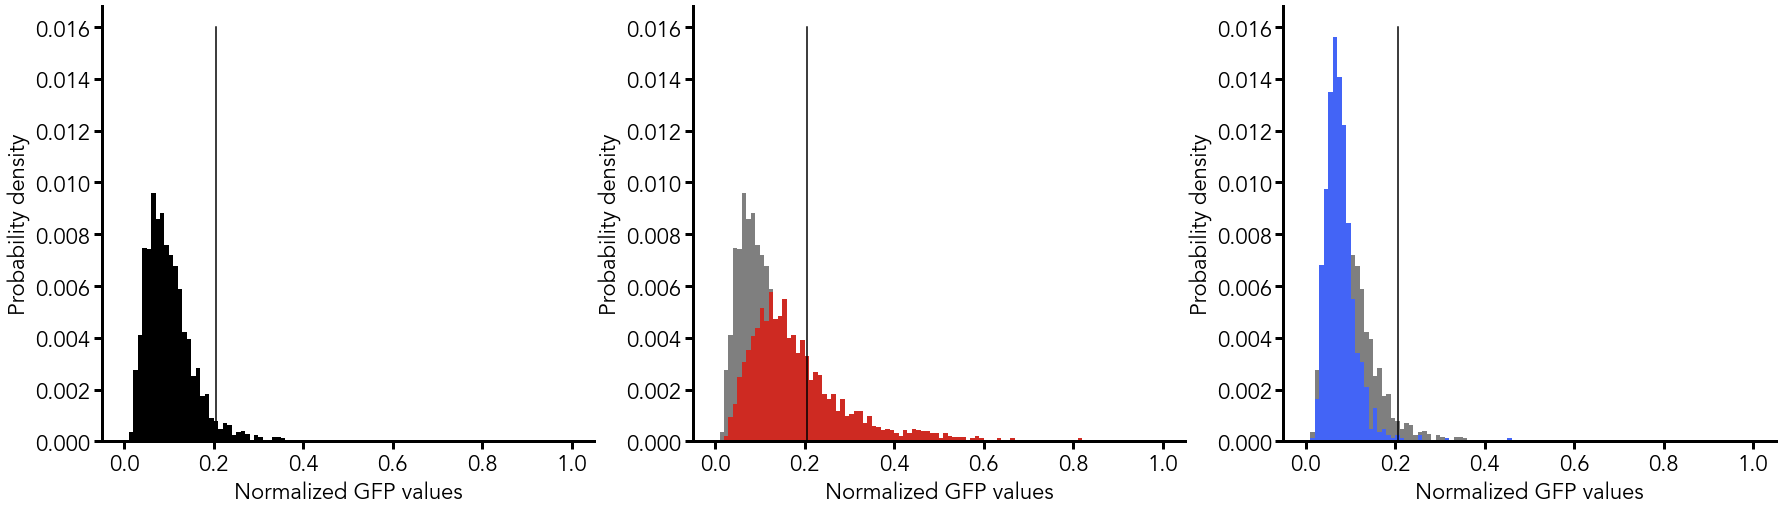

In [10]:
# collect all results

# analysis directory
dAnalysis = "/Users/angueyraaristjm/Documents/LiImaging/Analysis/CRtbx2F0s/m2Gt2T/"

# open file

# uninjected
### 20201009: imaged 3dpf and 5dpf larvae. Analyzing 5 dpf for paper
gene = 'wt'
wt_fPaths = ["20201009_5dpf_Rh22G_trb2T_wt_i09b",
          "20201009_5dpf_Rh22G_trb2T_wt_i09d",
          "20201009_5dpf_Rh22G_trb2T_wt_i10b",
          "20201009_5dpf_Rh22G_trb2T_wt_i10d",
          "20201009_5dpf_Rh22G_trb2T_wt_i11b",
          "20201009_5dpf_Rh22G_trb2T_wt_i11d",
          "20201009_5dpf_Rh22G_trb2T_wt_i12b",
          "20201009_5dpf_Rh22G_trb2T_wt_i12d",
         ]
# tbx2a
gene = 'tbx2a';
tbx2a_fPaths = ["20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b",
#                 "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b",  # is this supposed to be d????
                # #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08b", #very curved stack. would require oblique cut
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09b",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10b", #done; this could be example
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11b", #done; very clean L-cone seg
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12b",
                #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12d", # this in lens up
               ]
# tbx2b
gene = 'tbx2b';
tbx2b_fPaths = ["20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07b",
                "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07d",
                 "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08b",
                "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08d",
               ]
                
                
rName = 'lGtile'

wtResults = []
i=1;
for fPath in wt_fPaths:
    gene = 'wt'
    dOut = dAnalysis + gene + '/' + fPath + '/'
    results = np.load(dOut + 'quantificationGFP.npz')
    wtResults.append(results[rName])
    i=i+1;

aResults = []
i=1;
for fPath in tbx2a_fPaths:
    gene = 'tbx2a'
    dOut = dAnalysis + gene + '/' + fPath + '/'
    results = np.load(dOut + 'quantificationGFP.npz')
    aResults.append(results[rName])
    i=i+1;

bResults = []
i=1;
for fPath in tbx2b_fPaths:
    gene = 'tbx2b'
    dOut = dAnalysis + gene + '/' + fPath + '/'
    results = np.load(dOut + 'quantificationGFP.npz')
    bResults.append(results[rName])
    i=i+1;


# combine across images
wtResults = np.concatenate(wtResults).ravel()
aResults = np.concatenate(aResults).ravel()
bResults = np.concatenate(bResults).ravel()

# plot histogram
pdfV = True
# wtH, wtB = np.histogram(wtResults, bins = 50, density=pdfV)
# aH, aB = np.histogram(aResults, bins = 50, density=pdfV)
# bH, bB = np.histogram(bResults, bins = 50, density=pdfV)

# plot histogram but first calculate a fixed bin number for all genotypes
# allBins = np.histogram_bin_edges(np.concatenate([wtResults,aResults,bResults]).ravel(),bins='fd');
allBins = np.arange(0,1010,10);
allBinsC = (allBins[:-1] + allBins[1:]) / 2 # Centers
wtH, wtB = np.histogram(wtResults, bins = allBins, density=pdfV)
aH, aB = np.histogram(aResults, bins = allBins, density=pdfV)
bH, bB = np.histogram(bResults, bins = allBins, density=pdfV)

# # this can be used for cumulative distribution then normalized
# wtH = np.cumsum(wtH)/np.max(np.cumsum(wtH));
# aH = np.cumsum(aH)/np.max(np.cumsum(aH));
# bH = np.cumsum(bH)/np.max(np.cumsum(bH));

wt95CI = np.min(allBinsC[(np.cumsum(wtH))>.095])/1000;
wGBright = np.sum(wtH[allBinsC>wt95CI*1000]);
aGBright = np.sum(aH[allBinsC>wt95CI*1000]);
bGBright = np.sum(bH[allBinsC>wt95CI*1000]);

baseColor = 'w'
if (plotStyle=='light'):
    baseColor = 'k';

# fH, (axH1,axH2,axH3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
fH, (axH1,axH2,axH3) = plt.subplots(nrows=1, ncols=3, figsize=(30, 8))
axH1.stairs(wtH,wtB/1000, fill=True, color = baseColor, alpha = 1.0)
axH2.stairs(wtH,wtB/1000, fill=True, color = baseColor, alpha = 0.5)
axH3.stairs(wtH,wtB/1000, fill=True, color = baseColor, alpha = 0.5)
axH2.stairs(aH,aB/1000, fill=True, color = zfC['lws1'], alpha = 1)
axH3.stairs(bH,bB/1000, fill=True, color = zfC['sws2'], alpha = 1)


axH1.plot([wt95CI,wt95CI],[0,0.016],color=baseColor)
axH2.plot([wt95CI,wt95CI],[0,0.016],color=baseColor)
axH3.plot([wt95CI,wt95CI],[0,0.016],color=baseColor)


# axH.set_title('Distribution of GFP inside L cones')
for axH in (axH1,axH2,axH3):
    formatFigureMain(fH, axH, _)
    axH.set_xlabel('Normalized GFP values')
    if pdfV:
        axH.set_ylabel('Probability density')
    else:
        axH.set_ylabel('Counts')
## normalized
# axH.stairs(wtH/np.max(wtH),wtB, fill=True, color = 'k', alpha = 0.5)
# axH.stairs(aH/np.max(aH),aB, fill=True, color = 'r', alpha = 0.5)
# axH.stairs(bH/np.max(bH),bB, fill=True, color = 'b', alpha = 0.5)

dPath = '/Users/angueyraaristjm/Documents/LiLab/Manuscripts/2021_zfConeRNAseq/resources/'
# dPath = '/Users/angueyraaristjm/Documents/LiLab/Conferences/2021_RCS/resources/'
plt.savefig(dPath + "CRtbx2F0_LM_hist.svg", transparent=True, format="svg")

print('# cells of bright GFP cells: wt={0}, tbx2a={1}, tbx2b={2}'.format(wGBright*1000,aGBright*1000,bGBright*1000))

In [ ]:

# fH, (axH1,axH2,axH3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
fH, axH = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))


# plot histogram
pdfV = True
# wtH, wtB = np.histogram(wtResults, bins = 50, density=pdfV)
# aH, aB = np.histogram(aResults, bins = 50, density=pdfV)
# bH, bB = np.histogram(bResults, bins = 50, density=pdfV)

# plot histogram but first calculate a fixed bin number for all genotypes
# allBins = np.histogram_bin_edges(np.concatenate([wtResults,aResults,bResults]).ravel(),bins='fd');
allBins = np.arange(0,1010,10);
allBinsC = (allBins[:-1] + allBins[1:]) / 2 # Centers
wtH, wtB = np.histogram(wtResults, bins = allBins, density=pdfV)
aH, aB = np.histogram(aResults, bins = allBins, density=pdfV)
bH, bB = np.histogram(bResults, bins = allBins, density=pdfV)

# # this can be used for cumulative distribution then normalized
# wtH = np.cumsum(wtH)/np.max(np.cumsum(wtH));
# aH = np.cumsum(aH)/np.max(np.cumsum(aH));
# bH = np.cumsum(bH)/np.max(np.cumsum(bH));

wt95CI = np.min(allBinsC[(np.cumsum(wtH))>.095])/1000;
wGBright = np.sum(wtH[allBinsC>wt95CI*1000]);
aGBright = np.sum(aH[allBinsC>wt95CI*1000]);
bGBright = np.sum(bH[allBinsC>wt95CI*1000]);


axH.stairs(wtH,wtB/1000, fill=True, color = 'k', alpha = .5)
axH.stairs(aH,aB/1000, fill=True, color = zfC['lws1'], alpha = .5)
axH.stairs(bH,bB/1000, fill=True, color = zfC['sws2'], alpha = .5)


axH.plot([wt95CI,wt95CI],[0,0.016],color='w')

formatFigureMain(fH, axH, _)
# axH.set_title('Distribution of GFP inside L cones')
axH.set_xlabel('Normalized GFP values')
if pdfV:
    axH.set_ylabel('Probability density')
else:
    axH.set_ylabel('Counts')
## normalized
# axH.stairs(wtH/np.max(wtH),wtB, fill=True, color = 'k', alpha = 0.5)
# axH.stairs(aH/np.max(aH),aB, fill=True, color = 'r', alpha = 0.5)
# axH.stairs(bH/np.max(bH),bB, fill=True, color = 'b', alpha = 0.5)

# dPath = '/Users/angueyraaristjm/Documents/LiLab/Manuscripts/2021_zfConeRNAseq/resources/'
dPath = '/Users/angueyraaristjm/Documents/LiLab/Conferences/2021_RCS/resources/'
# plt.savefig(dPath + "CRtbx2F0_LM_hist.svg", transparent=True, format="svg")

print('# cells of bright GFP cells: wt={0}, tbx2a={1}, tbx2b={2}'.format(wGBright*1000,aGBright*1000,bGBright*1000))

In [ ]:
len(allBins)

In [ ]:
res = mannwhitneyu(wtH, bH, alternative="less", method="auto")
print(res)

In [ ]:
dPath

In [ ]:
# divide images into 1000 bins
mH, mB = np.histogram(viewer.layers['M_mip'].data.flatten(), bins = 1000)
lH, lB = np.histogram(viewer.layers['L_mip'].data.flatten(), bins = 1000)


fH, axH = plt.subplots(figsize=(8,8))
axH.stairs(lH,lB, fill=True, color = 'm', alpha = 0.5)
axH.stairs(mH,mB, fill=True, color = 'g', alpha = 0.5)

In [ ]:
viewer.close()

In [ ]:
viewer

```python
# change keybind for default actions:
@viewer.bind_key('F1', overwrite=True)
def eraserMode(viewer):
    viewer.layers.selection.active.mode = 'fill'
    viewer.layers.selection.active.mode = 'paint'
    viewer.layers.selection.active.mode = 'erase'
    viewer.layers.selection.active.mode = 'pick'
    viewer.layers.selection.active.mode = 'pan_zoom'

# napari native functions for other actions

@register_label_action(
    trans._(
        "Set the currently selected label to the largest used label plus one."
    ),
)
def new_label(layer):
    """Set the currently selected label to the largest used label plus one."""
    layer.selected_label = layer.data.max() + 1


@register_label_action(
    trans._("Decrease the currently selected label by one."),
)
def decrease_label_id(layer):
    layer.selected_label -= 1


@register_label_action(
    trans._("Increase the currently selected label by one."),
)
def increase_label_id(layer):
    layer.selected_label += 1

```